## Let's start with the main imports

In [1]:
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import astropy.units as u
from astropy.coordinates import EarthLocation, SkyCoord
from astropy.io import fits
from astropy.table import Table
from astropy.time import Time
from regions import PointSkyRegion
from gammapy.data import GTI, DataStore, Observation, observatory_locations
from gammapy.data.pointing import FixedPointingInfo, PointingMode
from gammapy.datasets import MapDataset, MapDatasetEventSampler
from gammapy.datasets.tests.test_map import get_map_dataset
from gammapy.irf import load_irf_dict_from_file
from gammapy.makers import MapDatasetMaker
from gammapy.maps import MapAxis, RegionNDMap, WcsGeom, Map
from gammapy.modeling import Fit
from gammapy.modeling.models import (
    ConstantSpectralModel,
    FoVBackgroundModel,
    GaussianSpatialModel,
    LightCurveTemplateTemporalModel,
    Models,
    PointSpatialModel,
    PowerLawSpectralModel,
    SkyModel,
)
from gammapy.utils.testing import requires_data

### Create the energy-dependent model

In [2]:
spatial_model = PointSpatialModel(
    lon_0="100 deg", lat_0="30 deg", frame="icrs"
)
spectral_model = ConstantSpectralModel(const="1 cm-2 s-1 TeV-1")

bkg_model = FoVBackgroundModel(dataset_name="my-dataset")    

time_bins = 720
time_min = np.arange(0, 3600, time_bins) * u.s
time_max = np.arange(720, 4320, time_bins) * u.s
edges = np.append(time_min, time_max[-1])
time_axis = MapAxis.from_edges(edges=edges, name="time", interp="log")

nbin = 10
energy_axis = MapAxis.from_energy_bounds(
    energy_min=0.2 * u.TeV, energy_max=100 * u.TeV, 
    nbin=nbin, name="energy"
)
data = (np.ones((len(time_min), energy_axis.nbin )) 
        * 1e-12 * u.cm**-2 * u.s**-1 * u.TeV**-1)

m = RegionNDMap.create(
    region=PointSkyRegion(center=spatial_model.position),
    axes=[energy_axis, time_axis],
)

ampl_model = np.array([2e-10, 8e-11, 5e-11, 3e-11, 1e-11]) * u.cm**-2 * u.TeV**-1 * u.s**-1
index_model = np.array([2.2, 2.0, 1.8, 1.6, 1.4])
for i in np.arange(len(time_min)):
    spec = PowerLawSpectralModel(index=index_model[i], 
                                 amplitude=ampl_model[i], 
                                 reference="1 TeV")
    data[i, :], _ = spec.evaluate_error(energy_axis.center)

m.data = np.array(data)
t_ref = Time(51544.00074287037, format="mjd", scale="tt")
temporal_model = LightCurveTemplateTemporalModel(m, t_ref=t_ref)

model = SkyModel(
    spatial_model=spatial_model,
    spectral_model=spectral_model,
    temporal_model=temporal_model,
    name="test-source",
)

models = [model, bkg_model]

In [3]:
np.shape(m.data), np.shape(data)
m.data[1,:,0,0]

array([1.07431835e-09, 3.09983798e-10, 8.94427191e-11, 2.58078005e-11,
       7.44658227e-12, 2.14863671e-12, 6.19967595e-13, 1.78885438e-13,
       5.16156010e-14, 1.48931645e-14])

#### How the model evolves:

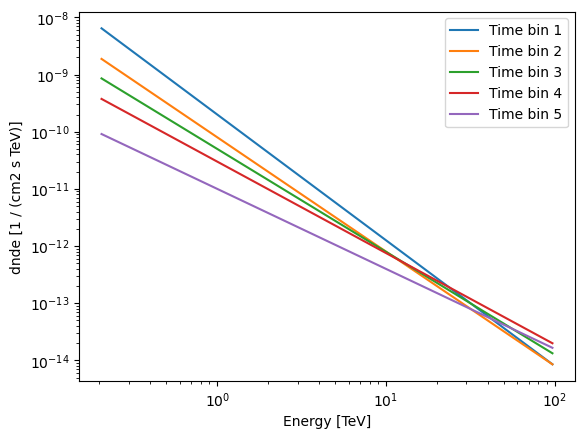

In [4]:
for i in np.arange(len(time_min)):
    spec = PowerLawSpectralModel(index=index_model[i], 
                                amplitude=ampl_model[i], 
                                reference="1 TeV")
    spec.plot([0.2,100]*u.TeV, label=f"Time bin {i+1}")
plt.legend()

### Make the observation and the dataset

In [5]:
path = Path("$GAMMAPY_DATA/cta-caldb")
irf_filename = "Prod5-South-20deg-AverageAz-14MSTs37SSTs.180000s-v0.1.fits.gz"

pointing = SkyCoord(100.0, 30.0, frame="icrs", unit="deg")
livetime = 1 * u.hr

In [6]:
irfs = load_irf_dict_from_file(path / irf_filename)
location = observatory_locations["cta_south"]

observation = Observation.create(
    obs_id=1001,
    pointing=pointing,
    livetime=livetime,
    irfs=irfs,
    location=location,
)

/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


In [7]:
energy_axis = MapAxis.from_energy_bounds("0.2 TeV", "100 TeV", nbin=5, per_decade=True)
energy_axis_true = MapAxis.from_energy_bounds(
    "0.05 TeV", "150 TeV", nbin=10, per_decade=True, name="energy_true"
)
migra_axis = MapAxis.from_bounds(0.5, 2, nbin=150, node_type="edges", name="migra")

geom = WcsGeom.create(
    skydir=pointing,
    width=(2, 2),
    binsz=0.02,
    frame="icrs",
    axes=[energy_axis],
)

In [8]:
empty = MapDataset.create(
    geom,
    energy_axis_true=energy_axis_true,
    migra_axis=migra_axis,
    name="my-dataset",
)
maker = MapDatasetMaker(selection=["exposure", "background", "psf", "edisp"])
dataset = maker.run(empty, observation)

dataset.models = models

In [9]:
# #quick check to determine how many counts we expect with the spectral models...
# dataset.models[0].spectral_model= PowerLawSpectralModel(index=index[4], 
#                                 amplitude=ampl[4], 
#                                 reference="1 TeV")
# dataset.models[0].temporal_model = None
# print(dataset)

In [10]:
print(dataset.models)

DatasetModels

Component 0: SkyModel

  Name                      : test-source
  Datasets names            : None
  Spectral model type       : ConstantSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : LightCurveTemplateTemporalModel
  Parameters:
    const                         :      1.000   +/-    0.00 1 / (cm2 s TeV)
    lon_0                         :    100.000   +/-    0.00 deg         
    lat_0                         :     30.000   +/-    0.00 deg         
    t_ref                 (frozen):  51544.000       d           

Component 1: FoVBackgroundModel

  Name                      : my-dataset-bkg
  Datasets names            : ['my-dataset']
  Spectral model type       : PowerLawNormSpectralModel
  Parameters:
    norm                          :      1.000   +/-    0.00             
    tilt                  (frozen):      0.000                   
    reference             (frozen):      1.000       TeV         




### Let's start the simulation

In [11]:
sampler = MapDatasetEventSampler(random_state=0, oversample_energy_factor=10)
events = sampler.run(dataset, observation)

In [12]:
idx = np.where(events.table["MC_ID"]==1)
len(idx[0])

7192

In [13]:
from astropy.coordinates import Angle, SkyCoord
from regions import CircleSkyRegion
src_position = SkyCoord(100.0, 30., frame="icrs", unit="deg")

on_region_radius = Angle("0.15 deg")
on_region = CircleSkyRegion(center=src_position, radius=on_region_radius)

src_events = events.select_region(on_region)

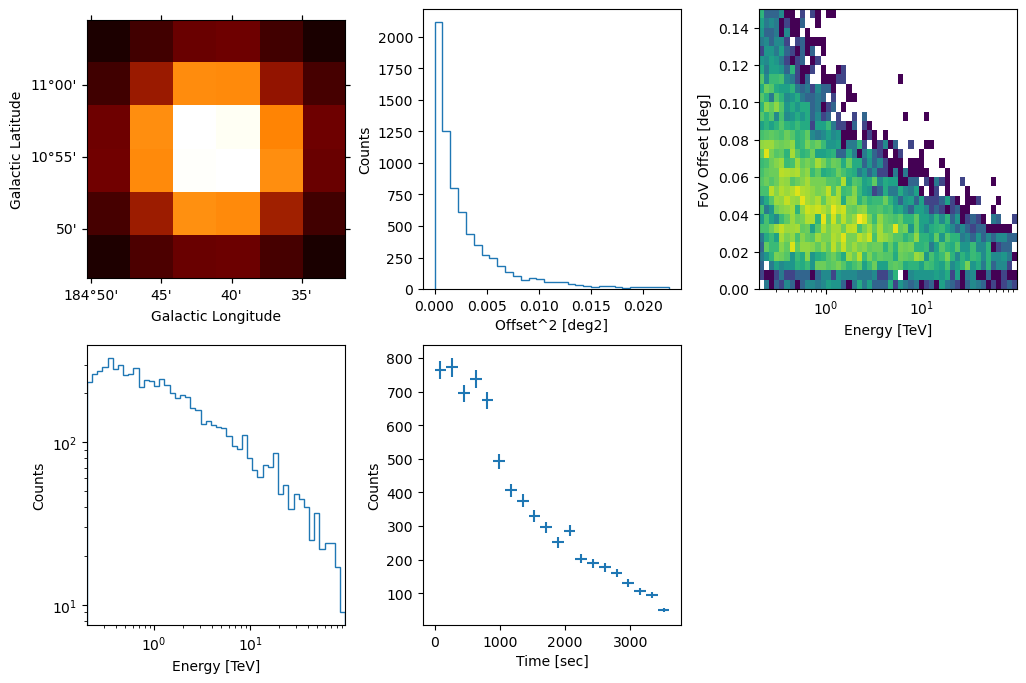

In [14]:
src_events.peek()

### Fit single time bins (test)

In [15]:
spec = PowerLawSpectralModel(index=2, 
                             amplitude=5e-11 * u.cm**-2 * u.s**-1 * u.TeV**-1, 
                             reference="1 TeV")

spatial_model = PointSpatialModel(
    lon_0="100 deg", lat_0="30 deg", frame="icrs"
)

model = SkyModel(
    spatial_model=spatial_model,
    spectral_model=spec,
    name="fit_source",
)

model.spatial_model.parameters[0].frozen=True
model.spatial_model.parameters[1].frozen=True

bkg_model = FoVBackgroundModel(dataset_name="my-dataset")    

model_fit = [model, bkg_model]

In [16]:
livetime = 200 * u.s

i=0
tstart = t_ref + (time_min[i] + 360 * u.s).to("d")
observation = Observation.create(
    obs_id=1001,
    pointing=pointing,
    livetime=livetime,
    irfs=irfs,
    location=location,
    tstart = tstart
)

dataset_fit = maker.run(empty, observation)

/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


In [17]:
filt_evt = events.select_time([observation.gti.time_start, observation.gti.time_stop])

In [18]:
counts = Map.from_geom(geom)
counts.fill_events(filt_evt)
dataset_fit.counts = counts
dataset_fit.models = model_fit
dataset_fit.models[1].spectral_model.parameters[0].frozen=True

print(dataset_fit.models)

DatasetModels

Component 0: SkyModel

  Name                      : fit_source
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                         :      2.000   +/-    0.00             
    amplitude                     :   5.00e-11   +/- 0.0e+00 1 / (cm2 s TeV)
    reference             (frozen):      1.000       TeV         
    lon_0                 (frozen):    100.000       deg         
    lat_0                 (frozen):     30.000       deg         

Component 1: FoVBackgroundModel

  Name                      : my-dataset-bkg
  Datasets names            : ['my-dataset']
  Spectral model type       : PowerLawNormSpectralModel
  Parameters:
    norm                  (frozen):      1.000                   
    tilt                  (frozen):      0.000                   
    reference             (frozen):      1.000       TeV         


In [19]:
fit = Fit()
result = fit.run(dataset_fit)
print(result)

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully..
	nfev       : 58
	total stat : 4092.89

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.



In [20]:
print(ampl_model[i], index_model[i])
result.parameters.to_table()

2e-10 1 / (cm2 s TeV) 2.2


type,name,value,unit,error,min,max,frozen,is_norm,link
str8,str9,float64,str14,float64,float64,float64,bool,bool,str1
spectral,index,2.1206e+00,,2.892e-02,nan,nan,False,False,
spectral,amplitude,1.4384e-10,cm-2 s-1 TeV-1,5.188e-12,nan,nan,False,True,
spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,False,
spatial,lon_0,1.0000e+02,deg,0.000e+00,nan,nan,True,False,
spatial,lat_0,3.0000e+01,deg,0.000e+00,-9.000e+01,9.000e+01,True,False,
spectral,norm,1.0000e+00,,0.000e+00,nan,nan,True,True,
spectral,tilt,0.0000e+00,,0.000e+00,nan,nan,True,False,
spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,False,


In [21]:
print(dataset_fit.models)

DatasetModels

Component 0: SkyModel

  Name                      : fit_source
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                         :      2.121   +/-    0.03             
    amplitude                     :   1.44e-10   +/- 5.2e-12 1 / (cm2 s TeV)
    reference             (frozen):      1.000       TeV         
    lon_0                 (frozen):    100.000       deg         
    lat_0                 (frozen):     30.000       deg         

Component 1: FoVBackgroundModel

  Name                      : my-dataset-bkg
  Datasets names            : ['my-dataset']
  Spectral model type       : PowerLawNormSpectralModel
  Parameters:
    norm                  (frozen):      1.000                   
    tilt                  (frozen):      0.000                   
    reference             (frozen):      1.000       TeV         


## Perform a number of sims

In [23]:
def make_model_fit():
    spec = PowerLawSpectralModel(index=2, 
                                 amplitude=5e-11 * u.cm**-2 * u.s**-1 * u.TeV**-1, 
                                 reference="1 TeV")

    spatial_model = PointSpatialModel(
        lon_0="100 deg", lat_0="30 deg", frame="icrs"
    )

    model = SkyModel(
        spatial_model=spatial_model,
        spectral_model=spec,
        name="fit_source",
    )

    model.spatial_model.parameters[0].frozen=True
    model.spatial_model.parameters[1].frozen=True

    bkg_model = FoVBackgroundModel(dataset_name="my-dataset")    

    model_fit = [model, bkg_model]
    model_fit[1].spectral_model.parameters[0].frozen=True
    
    return model_fit

In [24]:
def make_dataset_fit(i, empty, events, model_fit):
    livetime = 100 * u.s

    tref = Time(51544.00074287037, format="mjd", scale="tt")
    tstart = tref + (time_min[i] + 360 * u.s).to("d")
    observation = Observation.create(
        obs_id=1001,
        pointing=pointing,
        livetime=livetime,
        irfs=irfs,
        location=location,
        tstart = tstart
    )

    dataset = maker.run(empty, observation)
    filt_evt = events.select_time([tstart, tstart + livetime])

    counts = Map.from_geom(geom)
    counts.fill_events(filt_evt)
    dataset.counts = counts
    dataset.models = model_fit

    return dataset

#### Start the sims

In [25]:
Nsim = 100
amplitude = np.zeros((Nsim, len(time_min)))
amplitude_err = np.zeros((Nsim, len(time_min)))
index = np.zeros((Nsim, len(time_min)))
index_err = np.zeros((Nsim, len(time_min)))
norm_bkg = np.zeros((Nsim, len(time_min)))
norm_bkg_err = np.zeros((Nsim, len(time_min)))

for i in np.arange(Nsim):
    print(f"We are performing the simulation N#. {i}")
    sampler = MapDatasetEventSampler(random_state=i)
    events = sampler.run(dataset, observation)
    
    for j in np.arange(len(time_min)):
        print(f"We are fitting the time bin N#. {j}")
        model_fit = make_model_fit()
        dataset_fit = make_dataset_fit(j, empty, events, model_fit)
        fit = Fit()
        result = fit.run(dataset_fit)
        
        amplitude[i, j] = dataset_fit.models[0].spectral_model.parameters["amplitude"].value
        amplitude_err[i, j] = dataset_fit.models[0].spectral_model.parameters["amplitude"].error
        
        index[i, j] = dataset_fit.models[0].spectral_model.parameters["index"].value
        index_err[i, j] = dataset_fit.models[0].spectral_model.parameters["index"].error
        
        norm_bkg[i, j] = dataset_fit.models[1].spectral_model.parameters["norm"].value
        norm_bkg_err[i, j] = dataset_fit.models[1].spectral_model.parameters["norm"].error

We are performing the simulation N#. 0
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 1
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 2
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 3
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 4
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 5
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 6
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 7
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 8
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 9
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 10
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 11
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 12
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 13
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 14
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 15
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 16
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 17
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 18
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 19
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 20
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 21
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 22
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 23
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 24
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 25
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 26
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 27
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 28
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 29
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 30
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 31
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 32
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 33
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 34
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 35
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 36
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 37
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 38
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 39
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 40
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 41
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 42
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 43
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 44
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 45
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 46
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 47
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 48
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 49
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 50
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 51
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 52
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 53
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 54
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 55
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 56
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 57
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 58
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 59
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 60
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 61
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 62
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 63
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 64
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 65
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 66
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 67
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 68
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 69
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 70
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 71
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 72
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 73
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 74
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 75
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 76
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 77
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 78
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 79
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 80
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 81
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 82
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 83
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 84
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 85
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 86
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 87
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 88
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 89
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 90
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 91
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 92
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 93
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 94
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 95
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 96
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 97
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 98
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are performing the simulation N#. 99
We are fitting the time bin N#. 0


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 1


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 2


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 3


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


We are fitting the time bin N#. 4


/Users/fabiopintore/LAVORO/Gammapy/gammapy/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


In [26]:
#ampl_sim = np.array([5e-11, 2e-11, 1e-11, 5e-12, 1e-12]) * u.cm**-2 * u.TeV**-1 * u.s**-1
#index_sim = np.array([1, 1.5, 2., 2.5, 3.0])
#ampl_sim = np.array([5e-11, 2e-11, 8e-12, 3e-12, 1e-12]) * u.cm**-2 * u.TeV**-1 * u.s**-1
#index_sim = np.array([3, 2.5, 2., 1.5, 1.0])

In [27]:
#amplitude[:,3], index[:,3]

In [28]:
ampl_pull = (amplitude - ampl_model[None,:].value) / amplitude_err
index_pull = (index - index_model[None,:]) / index_err
#norm_bkg_pull = (norm_bkg - 1) / norm_bkg_err

In [33]:
#plt.hist?

Text(0.5, 1.0, 'Amplitude')

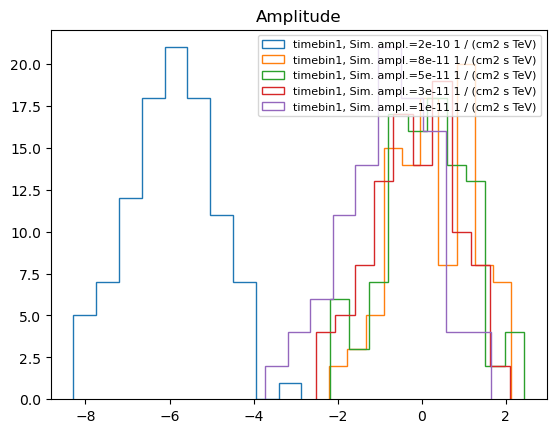

In [48]:
for i in np.arange(len(time_min)):
    plt.hist(ampl_pull[:,i], bins=10, label=f"timebin1, Sim. ampl.={ampl_model[i]}", histtype=u'step'),
    
plt.legend(prop={'size': 8})
plt.title("Amplitude")

Text(0.5, 1.0, 'Index')

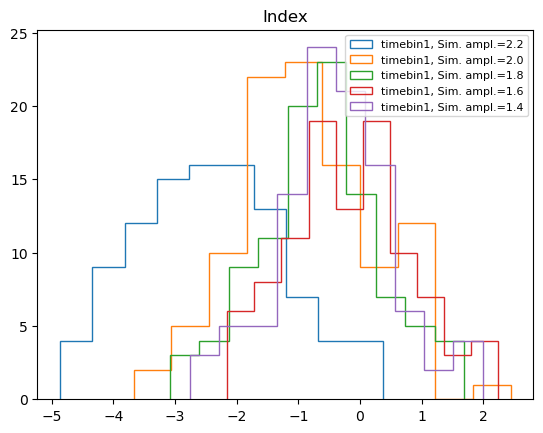

In [49]:
for i in np.arange(len(time_min)):
    plt.hist(index_pull[:,i], bins=10, label=f"timebin1, Sim. ampl.={index_model[i]}", histtype="step")

plt.legend(prop={'size': 8})
plt.title("Index")

In [86]:
# for i in np.arange(len(time_min)):
#     plt.hist(norm_bkg_pull[:,i],bins=20, label=f"timebin1, Sim. norm.=1")
#     plt.legend()
#     plt.title("BKG Norm")